In [1]:
from qepy import *
from yambopy import *
from qepy import PwIn
import matplotlib.pyplot as plt
import numpy as np
import GW_Routines as GW
import TD_Routines as TD

In [2]:
mpi = 8 #16 #32
omp = 1

## Time dependent analysis 

We study the time evolution of the ground state density subjected to a fast pulse

Choose a value of kpoints and the direction of the perturbing field. Create the fixSymm folder that contain the SAVE folder compatible with the simmetries broken by the perturbation. This folder is working path of the TD simulation.

In [3]:
kfold = 'yambo/k8'
fieldDirection = [1.0,1.0,1.0]

In [4]:
reload(TD)
path = TD.fixSymm(kfold,fieldDirection)

FixSymm folder already created


In [5]:
path

'yambo/k8/FixSymm'

Create and edit the TD input file. Then run the simulation.

In [6]:
# Field parameters
fieldInt =  100 #10 #kWLm2
fieldFreq = 1.55 #2.5 #eV
fieldWidth = 20 #fs

# Simulation parameters
RTstep = 1.0 #as - time step
NETime = 120.0 #fs - total simulation time
RTbands = [2,7] # the KS bands involved in the simulation

# Parallelization
RT_CPU = "%s.1.1.1"%mpi

In [8]:
reload(TD)
rtinput = 'rt_field'+str(fieldInt)+'_step'+str(RTstep)+'_bnd'+str(RTbands[0])+'-'+str(RTbands[1])+'.in'
rtoutFold = 'rt_field'+str(fieldInt)+'_step'+str(RTstep)+'_bnd'+str(RTbands[0])+'-'+str(RTbands[1])
TD.makeTDinput(path,rtinput,fieldDirection,fieldInt,fieldFreq,fieldWidth,RTstep,NETime,RTbands,RT_CPU)

In [108]:
#skip must be added....
#check if it useful to run yambo without deleting the job folder. What appens in this case?
TD.runYambo_rt(path,rtinput,rtoutFold,mpi,omp)

execute : cd yambo/k8/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 8 yambo_rt -F rt_field500_step1.0_bnd2-7.in -J rt_field500_step1.0_bnd2-7 -C rt_field500_step1.0_bnd2-7
done!


In [9]:
# parse the output files for data analysis

In [10]:
eFieldOut = 'o-'+rtoutFold+'.external_field'
carriesOut ='o-'+rtoutFold+'.carriers'

In [11]:
larray = GW.parserArrayFromFile(path+os.sep+rtoutFold+os.sep+eFieldOut)
time = []
eInt = []
fluence = []
for l in larray:
    time.append(l[0])
    eInt.append(l[7])
    fluence.append(100*l[8])

In [17]:
%matplotlib auto
plt.plot(time,eInt)
plt.plot(time,fluence)
plt.show()

Using matplotlib backend: TkAgg


In [13]:
larray = GW.parserArrayFromFile(path+os.sep+rtoutFold+os.sep+carriesOut)
time = []
dnElec = []
dnHoles = []
for l in larray:
    time.append(l[0])
    dnElec.append(l[2])
    dnHoles.append(l[3])

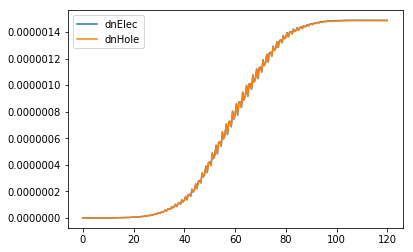

In [18]:
%matplotlib inline
plt.plot(time,dnElec,label='dnElec')
plt.plot(time,dnHoles,label='dnHole')
plt.legend()
plt.show()

Per andare avanti.
Guardare nella cartella di yambo-tests
/home/marco/Data/RICERCA/MANY BODY/Test/yambo-tests/TESTS/MAIN/Si_bulk/RT/INPUTS
dove ci sono vari file di input da studiare. In particolare

* si possono generare distribuzioni neq con ypp_rt (anche se ora non mi serve visto che l'ho fatto esplicitamente con il conto rt). Questo è descritto nei file di input 02_carriers_DB_ypp (credo) e si genera con ypp_rt -C (da controllare da -H di ypp_rt)
* fare post processing dei conti rt con ypp_rt. In questo caso si fa ypp_rt -n o e (tutto da controllare) e si generano file tipo 02_carriers_Fermi_fit_DB. Poi con ypp_rt -F <nomefile> -J <nomefoldercontoRT> si ottiene il plot 
* conto COHSEX con occupazioni neq (si fanno conti di tipo COHSEX perchè l'estensione eq->neq funziona in modo semplice solo se la Sigma è reale (o statica?)). Guardare l'input file 08_cohsex_10fs. E' un conto COHSEX standard con la stringa in più
    
    GfnRTdb= "f @ 0.1 ps < <folderconto RT>/ndb.RT_carriers"          # [EXTRT G] Database

la f indica le occupazioni

Ypp_rt post processing

In [19]:
yppTimeStep = 10.0 #fs
ypp_outfold = 'ypp_noe'

In [20]:
reload(TD)
TD.makeYPP_rtOccupationInput(path,RTbands,yppTimeStep)

remove file : yambo/k8/FixSymm/ypp.in
cd yambo/k8/FixSymm; ypp_rt -n o e -V qp


In [21]:
TD.runYPP_rt(path,'ypp.in',rtoutFold,'ypp_noe')

delete yambo/k8/FixSymm/ypp_noe
execute : cd yambo/k8/FixSymm; OMP_NUM_THREADS=1 mpirun -np 1 ypp_rt -F ypp.in -J rt_field100_step1.0_bnd2-7 -C ypp_noe
done!


what to to with these output file?

In [25]:
holes = 'o-'+rtoutFold+'.YPP-RT_occupations_DATA'
electrons = 'o-'+rtoutFold+'.YPP-RT_occupations_FIT_electrons'
val = holes

In [26]:
larray = GW.parserArrayFromFile(path+os.sep+ypp_outfold+os.sep+val)
energy = []
val_t1 = []
val_t2 = []
val_t3 = []
for l in larray:
    energy.append(l[0])
    val_t1.append(l[3])
    val_t2.append(l[7])
    val_t3.append(l[11])

In [31]:
%matplotlib auto
plt.plot(energy,val_t1)
plt.plot(energy,val_t2)
plt.plot(energy,val_t3)
plt.show()

Using matplotlib backend: TkAgg


Now perform a COHSEX calculation on top on the neq distribution

In [135]:
# take the starting point of the COHSEX calculation from the converged parameters of the HF ones
hf_kconv = 8
hf_G0_Gcompconv = 3.0 #Ha

In [136]:
yambo_eq = {8 : {'folder' :'yambo/k8'}}
yambo_neq = {8 : {'folder' :'yambo/k8/FixSymm'}}

In [137]:
W_Gcomp = [5.0] #Ha
W_nb = [50]
# compute the COHSEX correction only for the bands in the range
firstk = 1
lastk = 21 # the k index to compute the indirect band gap
firstbnd = 2
lastbnd = 7

In [138]:
GW.buildCOHSEX(yambo_eq,hf_kconv,hf_G0_Gcompconv,W_Gcomp,W_nb,firstk,lastk,firstbnd,lastbnd)
GW.buildCOHSEX(yambo_neq,hf_kconv,hf_G0_Gcompconv,W_Gcomp,W_nb,firstk,lastk,firstbnd,lastbnd)

In [63]:
# add manually the string
GfnRTdb= "f @ 0.1 ps < rt_field100_step1.0-bnd2-7/ndb.RT_carriers" # [EXTRT G] Database

In [64]:
# l'ho eseguito con yambo dovevo usare yambo_rt? credo sia la stessa cosa...

In [139]:
GW.runCOHSEX(yambo_neq,hf_kconv,mpi,omp,True)
GW.getCOHSEXresults(yambo_neq,hf_kconv)

execute : cd yambo/k8/FixSymm ; OMP_NUM_THREADS=1 mpirun -np 8 yambo -F cs_wGcomp5.0_wNb50.in -J cs_wGcomp5.0_wNb50 -C cs_wGcomp5.0_wNb50
done!
read file : yambo/k8/FixSymm/cs_wGcomp5.0_wNb50/o-cs_wGcomp5.0_wNb50.qp


In [140]:
# reload the computation for the equilibrium case
GW.runCOHSEX(yambo_eq,hf_kconv,mpi,omp,True)
GW.getCOHSEXresults(yambo_eq,hf_kconv)

skip the computation for : yambo/k8/cs_wGcomp5.0_wNb50/o-cs_wGcomp5.0_wNb50.qp
read file : yambo/k8/cs_wGcomp5.0_wNb50/o-cs_wGcomp5.0_wNb50.qp


In [141]:
results_neq = yambo_neq[8]['cs'][(5.0,50)]['results']
results_eq = yambo_eq[8]['cs'][5.0,50]['results']

In [142]:
print 'equilibrium indirect gap = ', GW.getBandGap(results_eq,4,5,1,21)
print 'non-equilibrium indirect gap = ', GW.getBandGap(results_neq,4,5,1,21)

equilibrium indirect gap =  1.773443
non-equilibrium indirect gap =  1.742104


In [143]:
# mi sembra che il risultato neq non sia dipendente dall'intensità del campo...